#Neural Network Approach to Identify AI-Generated and Human-Made Art
Group 8: Yanqi Su, Yile Xu, Yiwen Zhu

##The Business problem

In the contemporary field of artwork, the distinction between AI-generated and human-made has
become increasingly ambiguous, presenting a challenge for both creators and consumers in terms
of authenticity and valuation. Therefore, our project is aimed at addressing the critical need for
an effective way to identify whether the artwork is made by AI or humans. Our team will
combine machine learning and neural networks to create models, providing ways for analysis
and understanding of digital artworks.

# **Data Loading and necessary data pre-processing**
all the loading, preprossing including data pixel change and scc dataupload was done by Yanqi Su

for the image extraction and random selection, check the data extraction file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import normalize


ai_path = '/content/drive/MyDrive/BA865 Project/Image folder/ai_images_75'
human_path = '/content/drive/MyDrive/BA865 Project/Image folder/human_images_75_1'


def load_images_from_folder(folder_path, target_size=(75, 75)):
    image_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            image_data.append(img_array)
    return np.array(image_data)

ai_images = load_images_from_folder(ai_path)
human_images = load_images_from_folder(human_path)


In [ ]:
ai_images = normalize(ai_images, axis=1)
human_images = normalize(human_images, axis=1)

data = {
    'AI': ai_images,
    'Human': human_images
}

print('AI images shape:', ai_images.shape)
print('Human images shape:', human_images.shape)

AI images shape: (6300, 75, 75, 3)
Human images shape: (6300, 75, 75, 3)


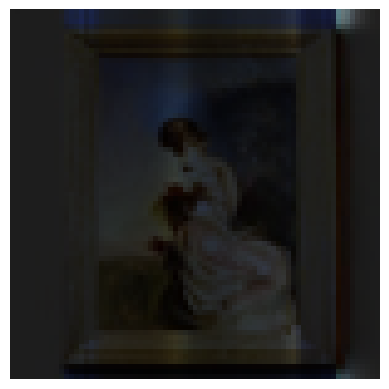

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(ai_images[1])
plt.axis('off')
plt.show()

# **Train Validation Test split**

In [ ]:
from sklearn.model_selection import train_test_split


def split_data(images, test_size=0.3):
    train, remaining = train_test_split(images, test_size=test_size, random_state=42)
    validation, test = train_test_split(remaining, test_size=1/3, random_state=42)
    return train, validation, test


train_ai, val_ai, test_ai = split_data(ai_images)
train_human, val_human, test_human = split_data(human_images)

train_images = np.vstack((train_ai, train_human))
val_images = np.vstack((val_ai, val_human))
test_images = np.vstack((test_ai, test_human))

train_labels = np.array(['AI'] * len(train_ai) + ['Human'] * len(train_human))
val_labels = np.array(['AI'] * len(val_ai) + ['Human'] * len(val_human))
test_labels = np.array(['AI'] * len(test_ai) + ['Human'] * len(test_human))

print('Train images shape:', train_images.shape)
print('Validation images shape:', val_images.shape)
print('Test images shape:', test_images.shape)
print('Train labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

Train images shape: (8820, 75, 75, 3)
Validation images shape: (2520, 75, 75, 3)
Test images shape: (1260, 75, 75, 3)
Train labels shape: (8820,)
Validation labels shape: (2520,)
Test labels shape: (1260,)


In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

train_labels_one_hot = to_categorical(train_labels_encoded)
val_labels_one_hot = to_categorical(val_labels_encoded)
test_labels_one_hot = to_categorical(test_labels_encoded)

# **Logistic Regression**
Logistic regression was done Katniss Zhu

In [ ]:
pip install torchvision

In [ ]:
ai_path = '/content/drive/MyDrive/BA865 Project/Image folder/ai_images'
human_path = '/content/drive/MyDrive/BA865 Project/Image folder/human_images'

from PIL import Image
from torchvision import transforms
import os
import torch

def load_images_from_folder(folder_path, target_size=(256, 256)):
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image_tensors = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img)
            image_tensors.append(img_tensor)
            filenames.append(filename)

    return torch.stack(image_tensors), filenames

ai_images_for_log, ai_filenames = load_images_from_folder(ai_path)
human_images_for_log, human_filenames = load_images_from_folder(human_path)



In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split

class ImageDataset(Dataset):
    def __init__(self, images, labels, filenames):
        self.images = images
        self.labels = labels
        self.filenames = filenames

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx], self.filenames[idx]

all_images = torch.cat((ai_images_for_log, human_images_for_log), dim=0)
all_labels = torch.cat((torch.zeros(len(ai_images_for_log)), torch.ones(len(human_images_for_log))), dim=0)
all_filenames = ai_filenames + human_filenames

full_dataset = ImageDataset(all_images, all_labels, all_filenames)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
def train_model(num_epochs, model, train_loader, val_loader, criterion, optimizer, patience=3):
    wandb.init(project="binary_classification")
    history = []
    best_val_loss = float('inf')
    no_improve_count = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = []
        for images, labels in train_loader:
            images = images.view(-1, input_dim).float()
            labels = labels.view(-1, 1).float()
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        avg_train_loss = sum(train_loss) / len(train_loader)

        model.eval()
        val_loss = []
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(-1, input_dim).float()
                labels = labels.view(-1, 1).float()
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss.append(loss.item())
                predicted = (outputs.data >= 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = sum(val_loss) / len(val_loader)
        val_accuracy = 100 * correct / total

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improve_count = 0
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print("Early stopping triggered.")
                break

        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_accuracy": val_accuracy
        })

        history.append({
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy
        })

    wandb.finish()
    return history

In [ ]:
enable_wandb = True
if enable_wandb:
  !pip install wandb -qU
  import wandb
  wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.3 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import wandb
import pandas as pd

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return torch.sigmoid(self.linear(x))

input_dim = 256 * 256 * 3
model = LogisticRegressionModel(input_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience):
    wandb.init(project="binary_classification")
    best_val_loss = float('inf')
    no_improve_count = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1).float()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels, _ in train_loader:
                images, labels = images.to(device), labels.to(device).unsqueeze(1).float()
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = outputs.round()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total

        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_accuracy": val_accuracy
        })

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improve_count = 0
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print("Early stopping triggered.")
                break

    wandb.finish()

num_epochs = 10
patience = 3
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience)

def predict_and_save_results(model, loader, device):
    model.eval()
    predictions = []
    filenames = []
    with torch.no_grad():
        for images, labels, paths in loader:
            images = images.to(device)
            outputs = model(images).round().cpu().numpy()
            predictions.extend(outputs.flatten())
            filenames.extend(paths)


    results_df = pd.DataFrame({
        'Filename': filenames,
        'Prediction': predictions
    })
    results_df.to_csv('test_predictions.csv', index=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predict_and_save_results(model, test_loader, device)

wandb: Currently logged in as: yanqisu (buyanqisu). Use `wandb login --relogin` to force relogin


Epoch [1/10], Train Loss: 1.0132, Val Loss: 4.1361, Val Accuracy: 0.5604
Epoch [2/10], Train Loss: 0.9278, Val Loss: 5.6465, Val Accuracy: 0.6821
Epoch [3/10], Train Loss: 0.9207, Val Loss: 3.2549, Val Accuracy: 0.6279
Epoch [4/10], Train Loss: 0.7717, Val Loss: 2.3452, Val Accuracy: 0.7329
Epoch [5/10], Train Loss: 0.7348, Val Loss: 2.4234, Val Accuracy: 0.6848
Epoch [6/10], Train Loss: 0.7312, Val Loss: 2.0791, Val Accuracy: 0.7625
Epoch [7/10], Train Loss: 0.6740, Val Loss: 1.7942, Val Accuracy: 0.7610
Epoch [8/10], Train Loss: 0.6902, Val Loss: 2.0450, Val Accuracy: 0.7268
Epoch [9/10], Train Loss: 0.5795, Val Loss: 1.8022, Val Accuracy: 0.7671
Epoch [10/10], Train Loss: 0.5932, Val Loss: 1.5406, Val Accuracy: 0.8011


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▇▄▄▃▃▃▁▁
val_accuracy,▁▅▃▆▅▇▇▆▇█
val_loss,▅█▄▂▃▂▁▂▁▁
epoch,9
train_loss,0.59319
val_accuracy,0.80113
val_loss,1.54064


Our logistic regression model is designed to perform binary classification on photos to determine whether they are AI-generated or human-produced. Throughout the project, we use an organized strategy that includes preprocessing images, creating a specialized dataset, developing data loaders, and methodically structuring the logistic regression architecture. The photos are first shrunk to uniform dimensions of 256x256 pixels, then turned into tensors and normalized using the known ImageNet mean and standard deviation values.

We chose simplicity over complexity when building our model, with a single linear layer and a sigmoid activation function that generates probability scores. The model is trained with a flat input of image data, and we use the binary cross-entropy loss function in conjunction with the Adam optimizer to modify the model parameters.

Training sessions are recorded using Weights & Biases (wandb), which allows us to closely monitor and display key parameters including training loss, validation loss, and validation accuracy. This tracking shows progressive gains, highlighted by a large rise in validation accuracy from the first to the last epoch, which begins at roughly 56% and ends slightly above 80%. Such an upward trajectory indicates that the model is capable of distinguishing between the two unique image groups.

Additionally, we incorporate an early stopping mechanism to counteract overfitting, triggered when there is no decrement in validation loss over a certain number of epochs, defined by the patience parameter.

Following training, we run predictions on the test dataset and carefully record the results and filenames in a CSV file for further analysis and any model upgrade opportunities. Finally, our logistic regression model shows excellent classification accuracy, with a strong ability to distinguish between AI-generated and human-sourced photos.

# **MLP model**


We have done a large amount of models using image size 75x75 for baseline model, experiment and CNN pretrain model code test. We selected a number of ** **key** **experiments** **results** on the weights and bias dashboard.  **(please note that not all experiments has been recorded, as there are a lot of unworkable  runs that we considered should not be put into the complete dashboard, therefore, we decided to delete them.  we have left it with 7 key experiment that is significant to our model)**

Here is the link towards the dashboard for MLP and CNN:
https://api.wandb.ai/links/865_08/sqs6huho

MLP was done by both Eli Xu and Yanqi Su, Eli Xu started the MLP with the basic model experiment (Adam, early stop, SGD) Yanqi Su finished the other hyper parameters.

In [ ]:
enable_wandb = True
if enable_wandb:
  !pip install wandb -qU
  import wandb
  wandb.login()

wandb: Currently logged in as: yxu18 (865_08). Use `wandb login --relogin` to force relogin


In [ ]:
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


wandb.init(project="Ai_Human")


config = wandb.config
config.learning_rate = 0.001
config.batch_size = 128
config.epochs = 10
config.dropout_rate = 0.5


model = Sequential([
    Flatten(input_shape=(75, 75, 3)),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(512, activation='linear', kernel_regularizer=l2(0.001)),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(config.dropout_rate),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=config.learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(
    train_images,
    train_labels_one_hot,
    batch_size=config.batch_size,
    validation_data=(val_images, val_labels_one_hot),
    epochs=config.epochs,
    callbacks=[WandbCallback()]
)

test_loss, test_accuracy = model.evaluate(test_images, test_labels_one_hot)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

wandb.log({"Test Loss": test_loss, "Test Accuracy": test_accuracy})

wandb.finish()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16875)             0         
                                                                 
 dense (Dense)               (None, 1024)              17281024  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 18069506 (68.93 MB)
Trainable params: 1806

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
69/69 [==============================] - ETA: 0s - loss: 3.1283 - accuracy: 0.5026

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_202943-xpi2xabn/files/model-best)... Done. 0.8s


69/69 [==============================] - 7s 67ms/step - loss: 3.1283 - accuracy: 0.5026 - val_loss: 2.0292 - val_accuracy: 0.5000
Epoch 2/10
69/69 [==============================] - ETA: 0s - loss: 1.7809 - accuracy: 0.5297

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_202943-xpi2xabn/files/model-best)... Done. 0.6s


69/69 [==============================] - 4s 57ms/step - loss: 1.7809 - accuracy: 0.5297 - val_loss: 1.5783 - val_accuracy: 0.5179
Epoch 3/10
65/69 [===========================>..] - ETA: 0s - loss: 1.4711 - accuracy: 0.5703

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_202943-xpi2xabn/files/model-best)... Done. 1.4s


69/69 [==============================] - 4s 64ms/step - loss: 1.4653 - accuracy: 0.5727 - val_loss: 1.3589 - val_accuracy: 0.6194
Epoch 4/10
67/69 [============================>.] - ETA: 0s - loss: 1.2948 - accuracy: 0.6081

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_202943-xpi2xabn/files/model-best)... Done. 1.4s


69/69 [==============================] - 4s 65ms/step - loss: 1.2922 - accuracy: 0.6091 - val_loss: 1.2307 - val_accuracy: 0.6290
Epoch 5/10
69/69 [==============================] - 1s 14ms/step - loss: 1.1912 - accuracy: 0.6203 - val_loss: 1.2797 - val_accuracy: 0.5250
Epoch 6/10
66/69 [===========================>..] - ETA: 0s - loss: 1.1354 - accuracy: 0.6200

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_202943-xpi2xabn/files/model-best)... Done. 0.7s


69/69 [==============================] - 4s 56ms/step - loss: 1.1325 - accuracy: 0.6215 - val_loss: 1.0621 - val_accuracy: 0.6714
Epoch 7/10
65/69 [===========================>..] - ETA: 0s - loss: 1.0450 - accuracy: 0.6584

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_202943-xpi2xabn/files/model-best)... Done. 0.8s


69/69 [==============================] - 4s 55ms/step - loss: 1.0442 - accuracy: 0.6567 - val_loss: 1.0096 - val_accuracy: 0.6810
Epoch 8/10
66/69 [===========================>..] - ETA: 0s - loss: 0.9946 - accuracy: 0.6746

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_202943-xpi2xabn/files/model-best)... Done. 0.8s


69/69 [==============================] - 4s 57ms/step - loss: 0.9935 - accuracy: 0.6745 - val_loss: 0.9643 - val_accuracy: 0.6917
Epoch 9/10
67/69 [============================>.] - ETA: 0s - loss: 0.9310 - accuracy: 0.6997

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_202943-xpi2xabn/files/model-best)... Done. 0.7s


69/69 [==============================] - 4s 57ms/step - loss: 0.9297 - accuracy: 0.7006 - val_loss: 0.9408 - val_accuracy: 0.6702
Epoch 10/10
65/69 [===========================>..] - ETA: 0s - loss: 0.8891 - accuracy: 0.7127

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_202943-xpi2xabn/files/model-best)... Done. 0.7s


40/40 [==============================] - 0s 3ms/step - loss: 0.9226 - accuracy: 0.6484
Test Loss: 0.9226065278053284, Test Accuracy: 0.6484127044677734


Test Accuracy,▁
Test Loss,▁
accuracy,▁▂▃▅▅▅▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▂▅▆▂▇██▇▇
val_loss,█▅▄▃▃▂▂▁▁▁
Test Accuracy,0.64841
Test Loss,0.92261
accuracy,0.71281
best_epoch,9


Our baseline MLP employs TensorFlow and Keras. The architecture of this model contains a Flatten layer to convert input images into 1D array, followed by multiple Dense layers with both linear and ReLU activation to capture complex patterns. We choose L2 regularization to mitigate the risk of overfitting and a dropout layer at rate of 0.5 to enhance generalization. Then, the model was compiled with Adam optimizer at a learning rate of 0.001 to ensure efficient convergence. This model is trained on over 10 epochs with a batch size of 128 to optimize the performance and efficiency. Baseline MLP model achieve final validation accuracy of 67.22%, which suggest that MLP, even with complex architecture, it does not give out a good result, which may be due to the potential overfitting risk.

# **MLP with weigh decay**

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

wandb.init(project="Ai_Human")


config = wandb.config
config.img_dimensions = (75, 75, 3)
config.output_size = 2
config.batch_size = 128
config.learning_rate = 0.001
config.epochs = 10
config.weight_decay = 0.001
config.dropout_rate = 0.5


model = Sequential([
    Flatten(input_shape=config.img_dimensions),
    Dense(1024, activation='relu', kernel_regularizer=l2(config.weight_decay)),
    Dense(512, activation='linear', kernel_regularizer=l2(config.weight_decay)),
    Dense(512, activation='relu', kernel_regularizer=l2(config.weight_decay)),
    Dropout(config.dropout_rate),
    Dense(config.output_size, activation='softmax')
])


model.compile(optimizer=Adam(learning_rate=config.learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

history = model.fit(
    train_images,
    train_labels_one_hot,
    batch_size=config.batch_size,
    validation_data=(val_images, val_labels_one_hot),
    epochs=config.epochs,
    callbacks=[WandbCallback()]
)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 16875)             0         
                                                                 
 dense_4 (Dense)             (None, 1024)              17281024  
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 18069506 (68.93 MB)
Trainable params: 18

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_203626-70kbxwcn/files/model-best)... Done. 0.7s


69/69 [==============================] - 5s 59ms/step - loss: 2.6755 - accuracy: 0.5115 - val_loss: 1.7839 - val_accuracy: 0.4996
Epoch 2/10
66/69 [===========================>..] - ETA: 0s - loss: 1.5678 - accuracy: 0.5672

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_203626-70kbxwcn/files/model-best)... Done. 2.1s


69/69 [==============================] - 5s 77ms/step - loss: 1.5621 - accuracy: 0.5651 - val_loss: 1.3880 - val_accuracy: 0.6246
Epoch 3/10
69/69 [==============================] - ETA: 0s - loss: 1.3224 - accuracy: 0.5841

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_203626-70kbxwcn/files/model-best)... Done. 0.7s


69/69 [==============================] - 4s 55ms/step - loss: 1.3224 - accuracy: 0.5841 - val_loss: 1.2215 - val_accuracy: 0.6266
Epoch 4/10
65/69 [===========================>..] - ETA: 0s - loss: 1.1897 - accuracy: 0.6031

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_203626-70kbxwcn/files/model-best)... Done. 0.8s


69/69 [==============================] - 4s 60ms/step - loss: 1.1884 - accuracy: 0.6011 - val_loss: 1.1712 - val_accuracy: 0.5183
Epoch 5/10
66/69 [===========================>..] - ETA: 0s - loss: 1.1253 - accuracy: 0.5932

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_203626-70kbxwcn/files/model-best)... Done. 0.7s


69/69 [==============================] - 4s 55ms/step - loss: 1.1244 - accuracy: 0.5922 - val_loss: 1.0960 - val_accuracy: 0.6476
Epoch 6/10
67/69 [============================>.] - ETA: 0s - loss: 1.0731 - accuracy: 0.5983

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_203626-70kbxwcn/files/model-best)... Done. 0.8s


69/69 [==============================] - 5s 67ms/step - loss: 1.0725 - accuracy: 0.5991 - val_loss: 1.0205 - val_accuracy: 0.6484
Epoch 7/10
67/69 [============================>.] - ETA: 0s - loss: 1.0054 - accuracy: 0.6250

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_203626-70kbxwcn/files/model-best)... Done. 0.8s


69/69 [==============================] - 4s 55ms/step - loss: 1.0060 - accuracy: 0.6232 - val_loss: 0.9716 - val_accuracy: 0.6528
Epoch 8/10
69/69 [==============================] - 1s 14ms/step - loss: 0.9575 - accuracy: 0.6412 - val_loss: 0.9756 - val_accuracy: 0.5651
Epoch 9/10
66/69 [===========================>..] - ETA: 0s - loss: 0.9435 - accuracy: 0.6170

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_203626-70kbxwcn/files/model-best)... Done. 1.5s


69/69 [==============================] - 4s 65ms/step - loss: 0.9430 - accuracy: 0.6166 - val_loss: 0.9616 - val_accuracy: 0.5972
Epoch 10/10
66/69 [===========================>..] - ETA: 0s - loss: 0.8792 - accuracy: 0.6584

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_203626-70kbxwcn/files/model-best)... Done. 2.1s


69/69 [==============================] - 5s 74ms/step - loss: 0.8790 - accuracy: 0.6582 - val_loss: 0.8517 - val_accuracy: 0.6813


Here, we incorporated weight decay to further address the overfitting to improve the model’s capability. In this model, most of the configuration including learning rate, batch size and epochs remains the same. The modification is based on applying L2 regularization for each dense layer, allowing us to compare the model focusing on the impact of weight decay. MLP with weight decay aiming to reduce the overfitting risk by implementing regularization. With final validation accuracy of 68.13%, this model improves a little compared with MLP baseline, but still underperforms with logistics regression.

# **CNN with Max Pooling**

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

wandb.init(project="Ai_Human", config={
    "learning_rate": 0.001,
    "epochs": 10,
    "batch_size": 128
})


model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(75, 75, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),  # Flatten layer
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])


model.compile(optimizer=Adam(learning_rate=wandb.config.learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(
    train_images,
    train_labels_one_hot,
    batch_size=wandb.config.batch_size,
    epochs=wandb.config.epochs,
    validation_data=(val_images, val_labels_one_hot),
    callbacks=[WandbCallback()]
)


accuracy,▁▄▄▅▅▅▆▇▆█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▆▆▂▇▇▇▄▅█
val_loss,█▅▄▃▃▂▂▂▂▁
accuracy,0.65816
best_epoch,9
best_val_loss,0.85168
epoch,9
loss,0.879
val_accuracy,0.68135


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 73, 73, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 17, 17, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 18496)             0         
                                                                 
 dense_18 (Dense)            (None, 512)              

67/69 [============================>.] - ETA: 0s - loss: 0.5278 - accuracy: 0.7262

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_204447-dtg2hs95/files/model-best)... Done. 0.4s


69/69 [==============================] - 6s 68ms/step - loss: 0.5254 - accuracy: 0.7287 - val_loss: 0.4247 - val_accuracy: 0.8083
Epoch 2/10
69/69 [==============================] - 2s 24ms/step - loss: 0.4044 - accuracy: 0.8194 - val_loss: 0.4306 - val_accuracy: 0.8016
Epoch 3/10
67/69 [============================>.] - ETA: 0s - loss: 0.3615 - accuracy: 0.8382

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_204447-dtg2hs95/files/model-best)... Done. 0.4s


69/69 [==============================] - 3s 51ms/step - loss: 0.3631 - accuracy: 0.8376 - val_loss: 0.4039 - val_accuracy: 0.8083
Epoch 4/10
68/69 [============================>.] - ETA: 0s - loss: 0.3295 - accuracy: 0.8582

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_204447-dtg2hs95/files/model-best)... Done. 0.4s


69/69 [==============================] - 3s 51ms/step - loss: 0.3290 - accuracy: 0.8586 - val_loss: 0.3979 - val_accuracy: 0.8290
Epoch 5/10
67/69 [============================>.] - ETA: 0s - loss: 0.2967 - accuracy: 0.8729

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_204447-dtg2hs95/files/model-best)... Done. 0.4s


69/69 [==============================] - 4s 52ms/step - loss: 0.2960 - accuracy: 0.8727 - val_loss: 0.3563 - val_accuracy: 0.8425
Epoch 6/10
69/69 [==============================] - ETA: 0s - loss: 0.2640 - accuracy: 0.8863

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240424_204447-dtg2hs95/files/model-best)... Done. 0.4s


69/69 [==============================] - 4s 52ms/step - loss: 0.2640 - accuracy: 0.8863 - val_loss: 0.3179 - val_accuracy: 0.8595
Epoch 7/10
69/69 [==============================] - 2s 23ms/step - loss: 0.2173 - accuracy: 0.9099 - val_loss: 0.3311 - val_accuracy: 0.8587
Epoch 8/10
69/69 [==============================] - 2s 23ms/step - loss: 0.1838 - accuracy: 0.9260 - val_loss: 0.3228 - val_accuracy: 0.8595
Epoch 9/10
69/69 [==============================] - 2s 23ms/step - loss: 0.1583 - accuracy: 0.9381 - val_loss: 0.3846 - val_accuracy: 0.8579
Epoch 10/10
69/69 [==============================] - 2s 22ms/step - loss: 0.1150 - accuracy: 0.9575 - val_loss: 0.3328 - val_accuracy: 0.8683


Then, we decided to add max pooling into the architecture of our model to enhance feature detection and computational load reduction. In this model, we combine convolutional layers with max pooling steps to capture the most essential elements, allowing us to improve the generalization capability of the model and achieve higher accuracy. The model presents a very ideal solution, with 86.83%. Indicating that with dimensionality reduction combined with convolutional layers, it can improve the model performance on complex image classification.

# **CNN Pretain with 1 relu layer**

All the CNN base and other test models are done by Eli Xu

The final decision and code for InceptionV3 was done as a team

Weights and Bias section are done by Eli Xu

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3

batch_size = 32
learning_rate = 0.0001
epochs = 10
input_shape = (75, 75, 3)

In [ ]:
import wandb
from wandb.keras import WandbCallback


wandb.init(project="Ai_Human", config={
    "learning_rate": learning_rate,
    "epochs": epochs,
    "batch_size": batch_size,
    "loss_function": "categorical_crossentropy"
})

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=wandb.config.learning_rate),loss=wandb.config.loss_function,metrics=['accuracy'])

config = wandb.config
for epoch in range(config.epochs):
    history = model.fit(
        train_images, train_labels_one_hot,
        epochs=1,  # Fit one epoch at a time
        batch_size=config.batch_size,
        validation_data=(val_images, val_labels_one_hot)
    )

    wandb.log({
        "epoch": epoch +1,
        "loss": history.history['loss'][0],
        "accuracy": history.history['accuracy'][0],
        "val_loss": history.history['val_loss'][0],
        "val_accuracy": history.history['val_accuracy'][0]
    })


wandb.finish()

276/276 [==============================] - 143s 518ms/step - loss: 0.0270 - accuracy: 0.9904 - val_loss: 0.2185 - val_accuracy: 0.9325


accuracy,▁▅▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁█▇██▇████
val_loss,█▁▁▁▁▂▁▂▁▁
accuracy,0.99036
epoch,10
loss,0.02695
val_accuracy,0.93254
val_loss,0.2185


## Awesome, now I'm interested in directly attach the pretrain model to the output layer

In [ ]:
wandb.init(project="Ai_Human", config={
    "learning_rate": 0.0001,
    "epochs": 10,
    "batch_size": 32,
    "loss_function": "categorical_crossentropy"
})

config = wandb.config


base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
x = GlobalAveragePooling2D()(base_model.output)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=config.learning_rate),
              loss=config.loss_function,
              metrics=['accuracy'])

for epoch in range(config.epochs):
    history = model.fit(
        train_images, train_labels_one_hot,
        epochs=1,
        batch_size=config.batch_size,
        validation_data=(val_images, val_labels_one_hot)
    )

    wandb.log({
        "epoch": epoch +1,
        "loss": history.history['loss'][0],
        "accuracy": history.history['accuracy'][0],
        "val_loss": history.history['val_loss'][0],
        "val_accuracy": history.history['val_accuracy'][0]
    })


wandb.finish()

276/276 [==============================] - 141s 509ms/step - loss: 0.0310 - accuracy: 0.9904 - val_loss: 0.2461 - val_accuracy: 0.9278


accuracy,▁▅▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▁▁▁▁▁▁
val_accuracy,▁▇▇███▇███
val_loss,█▁▁▂▂▂▃▁▂▂
accuracy,0.99036
epoch,10
loss,0.031
val_accuracy,0.92778
val_loss,0.24613


To further advance our exploration, we integrated a Convolutional Neural Network (CNN) leveraging the sophisticated InceptionV3 architecture as a pre-trained foundation. This model, augmented with GlobalAveragePooling2D and dense layers utilizing the ReLU activation function, was trained with a modest learning rate of 0.0001 across 10 epochs and a batch size of 32. Impressively, this basic CNN model surpassed previous MLP benchmarks, achieving a remarkable validation accuracy of 93.25% and minimizing validation loss to 21.85%. This demonstrates the inherent advantages of CNNs for image-related tasks. Furthermore, we assessed the efficacy of InceptionV3 with a direct output layer, which also showed commendable results with a validation accuracy of 92.78% and a loss of 24.61%, indicating its robustness even without additional dense layers and still significantly outperforming MLP models and logistic regression.

# **scc cnn with 256*256 pixel size**

As a recommendation from professor, we decided to use the InceptionV3 pretrain CNN model on SCC with it's originla 256*256 image size. We directly migrate the code result from SCC to Colab for demonstration.

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import normalize

ai_path = 'ai_images/ai_images'
human_path = 'human_images/human_images'

def load_images_from_folder(folder_path, target_size=(256, 256)):
    image_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            image_data.append(img_array)
    return np.array(image_data)

ai_images = load_images_from_folder(ai_path)
human_images = load_images_from_folder(human_path)



ai_images = normalize(ai_images, axis=1)
human_images = normalize(human_images, axis=1)

data = {
    'AI': ai_images,
    'Human': human_images
}


print('AI images shape:', ai_images.shape)
print('Human images shape:', human_images.shape)

from sklearn.model_selection import train_test_split


def split_data(images, test_size=0.3):
    train, remaining = train_test_split(images, test_size=test_size, random_state=42)
    validation, test = train_test_split(remaining, test_size=1/3, random_state=42)
    return train, validation, test


train_ai, val_ai, test_ai = split_data(ai_images)
train_human, val_human, test_human = split_data(human_images)


train_images = np.vstack((train_ai, train_human))
val_images = np.vstack((val_ai, val_human))
test_images = np.vstack((test_ai, test_human))


train_labels = np.array(['AI'] * len(train_ai) + ['Human'] * len(train_human))
val_labels = np.array(['AI'] * len(val_ai) + ['Human'] * len(val_human))
test_labels = np.array(['AI'] * len(test_ai) + ['Human'] * len(test_human))


print('Train images shape:', train_images.shape)
print('Validation images shape:', val_images.shape)
print('Test images shape:', test_images.shape)
print('Train labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)


train_labels_one_hot = to_categorical(train_labels_encoded)
val_labels_one_hot = to_categorical(val_labels_encoded)
test_labels_one_hot = to_categorical(test_labels_encoded)

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3

batch_size = 32
learning_rate = 0.0001
epochs = 10
input_shape = (256, 256, 3)

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(train_images, train_labels_one_hot, epochs=epochs, batch_size=batch_size,
                    validation_data=(val_images, val_labels_one_hot))

AI images shape: (6300, 256, 256, 3)
Human images shape: (6300, 256, 256, 3)
Train images shape: (8820, 256, 256, 3)
Validation images shape: (2520, 256, 256, 3)
Test images shape: (1260, 256, 256, 3)
Train labels shape: (8820,)
Validation labels shape: (2520,)
Test labels shape: (1260,)


Model: "functional_3"

 Trainable params: 2,100,226 (8.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 236s 833ms/step - accuracy: 0.7706 - loss: 0.4644 - val_accuracy: 0.8560 - val_loss: 0.3061
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 224s 813ms/step - accuracy: 0.8883 - loss: 0.2732 - val_accuracy: 0.8718 - val_loss: 0.2882
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 262s 814ms/step - accuracy: 0.9066 - loss: 0.2327 - val_accuracy: 0.8810 - val_loss: 0.2814
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 224s 814ms/step - accuracy: 0.9252 - loss: 0.1941 - val_accuracy: 0.8726 - val_loss: 0.2988
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 224s 814ms/step - accuracy: 0.9364 - loss: 0.1706 - val_accuracy: 0.8992 - val_loss: 0.2463
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 225s 817ms/step - accuracy: 0.9460 - loss: 0.1395 - val_accuracy: 0.8960 - val_loss: 0.2554
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 225s 817ms/step - accuracy: 0.9630 - loss: 0.1189 - val_accuracy: 0.9020 - val_loss: 0.2415
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 225s 817ms/step - accuracy: 0.9716 -

Taking into account the feedback from our midterm review, we chose to adapt our pre-trained model to accommodate the inherent pixel dimensions of our dataset, utilizing the InceptionV3 architecture to classify images at their native resolution of 256x256 pixels on the SCC platform. This decision led us to develop a more sophisticated preprocessing pipeline to fully exploit TensorFlow's capabilities. The refined SCC CNN model demonstrated its effectiveness with a solid validation accuracy of 90.40% and a validation loss of 25.11%. While this performance did not surpass that of our basic CNN, we hypothesize that discrepancies could be attributed to differences in the computational platforms used.

# **Test prediction outputting**

As we wanted to use the best model that was performed before (CNN pretrian with 1 relu layer) and do prediction on the test set.

To be able to check the output labels easier, we decided to reload the image dataset and include the image file name in, and output it with the decoded image and predicted labels.Feed image and label into the model and use the model to generate output labels. Finally, we extract data with image name and image decode text and encoded them back to randomly demonstrate 30 images.

In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import normalize

ai_path = '/content/drive/MyDrive/BA865 Project/Image folder/ai_images_75'
human_path = '/content/drive/MyDrive/BA865 Project/Image folder/human_images_75_1'


def load_images_and_filenames(folder_path, target_size=(75, 75)):
    image_data = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            image_data.append(img_array)
            filenames.append(filename)
    return np.array(image_data), filenames


ai_images, ai_filenames = load_images_and_filenames(ai_path)
human_images, human_filenames = load_images_and_filenames(human_path)

ai_images = normalize(ai_images, axis=1)
human_images = normalize(human_images, axis=1)

data = {
    'AI': (ai_images, ai_filenames),
    'Human': (human_images, human_filenames)
}

In [ ]:

ai_images = normalize(ai_images, axis=1)
human_images = normalize(human_images, axis=1)

data = {
    'AI': ai_images,
    'Human': human_images
}

print('AI images shape:', ai_images.shape)
print('Human images shape:', human_images.shape)

AI images shape: (6300, 75, 75, 3)
Human images shape: (6300, 75, 75, 3)


In [ ]:
from sklearn.model_selection import train_test_split

def split_data(images, test_size=0.3):
    train, remaining = train_test_split(images, test_size=test_size, random_state=42)
    validation, test = train_test_split(remaining, test_size=1/3, random_state=42)
    return train, validation, test

train_ai, val_ai, test_ai = split_data(ai_images)
train_human, val_human, test_human = split_data(human_images)

train_images = np.vstack((train_ai, train_human))
val_images = np.vstack((val_ai, val_human))
test_images = np.vstack((test_ai, test_human))

train_labels = np.array(['AI'] * len(train_ai) + ['Human'] * len(train_human))
val_labels = np.array(['AI'] * len(val_ai) + ['Human'] * len(val_human))
test_labels = np.array(['AI'] * len(test_ai) + ['Human'] * len(test_human))

print('Train images shape:', train_images.shape)
print('Validation images shape:', val_images.shape)
print('Test images shape:', test_images.shape)
print('Train labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

Train images shape: (8820, 75, 75, 3)
Validation images shape: (2520, 75, 75, 3)
Test images shape: (1260, 75, 75, 3)
Train labels shape: (8820,)
Validation labels shape: (2520,)
Test labels shape: (1260,)


In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

train_labels_one_hot = to_categorical(train_labels_encoded)
val_labels_one_hot = to_categorical(val_labels_encoded)
test_labels_one_hot = to_categorical(test_labels_encoded)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3

batch_size = 32
learning_rate = 0.0001
epochs = 10
input_shape = (75, 75, 3)

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_images, train_labels_one_hot,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(val_images, val_labels_one_hot))

Epoch 1/10
276/276 [==============================] - 43s 62ms/step - loss: 0.4275 - accuracy: 0.7976 - val_loss: 0.5389 - val_accuracy: 0.7714
Epoch 2/10
276/276 [==============================] - 15s 54ms/step - loss: 0.2030 - accuracy: 0.9178 - val_loss: 0.2456 - val_accuracy: 0.9056
Epoch 3/10
276/276 [==============================] - 15s 54ms/step - loss: 0.1131 - accuracy: 0.9603 - val_loss: 0.2390 - val_accuracy: 0.9135
Epoch 4/10
276/276 [==============================] - 15s 54ms/step - loss: 0.0741 - accuracy: 0.9751 - val_loss: 0.2361 - val_accuracy: 0.9234
Epoch 5/10
276/276 [==============================] - 15s 55ms/step - loss: 0.0603 - accuracy: 0.9787 - val_loss: 0.2440 - val_accuracy: 0.9163
Epoch 6/10
276/276 [==============================] - 15s 55ms/step - loss: 0.0454 - accuracy: 0.9855 - val_loss: 0.2562 - val_accuracy: 0.9250
Epoch 7/10
276/276 [==============================] - 15s 55ms/step - loss: 0.0372 - accuracy: 0.9871 - val_loss: 0.2148 - val_accuracy:

In [ ]:
import pandas as pd
import base64
from io import BytesIO
from tensorflow.keras.preprocessing.image import array_to_img

def image_to_base64(img_array):
    """Converts an image array to a Base64 string."""
    pil_image = array_to_img(img_array)
    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode()

predicted_probabilities = model.predict(test_images)
predicted_labels = predicted_probabilities.argmax(axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_labels)


images_base64 = [image_to_base64(img) for img in test_images]

test_filenames = ai_filenames[len(train_ai) + len(val_ai):] + human_filenames[len(train_human) + len(val_human):]

df = pd.DataFrame({
    'Filename': test_filenames,
    'Image_Base64': images_base64,
    'Label': predicted_labels
})

df.to_csv('test_set_predictions.csv', index=False)

print("CSV file has been created with filenames, Base64-encoded images, and labels.")

40/40 [==============================] - 2s 16ms/step
CSV file has been created with filenames, Base64-encoded images, and labels.


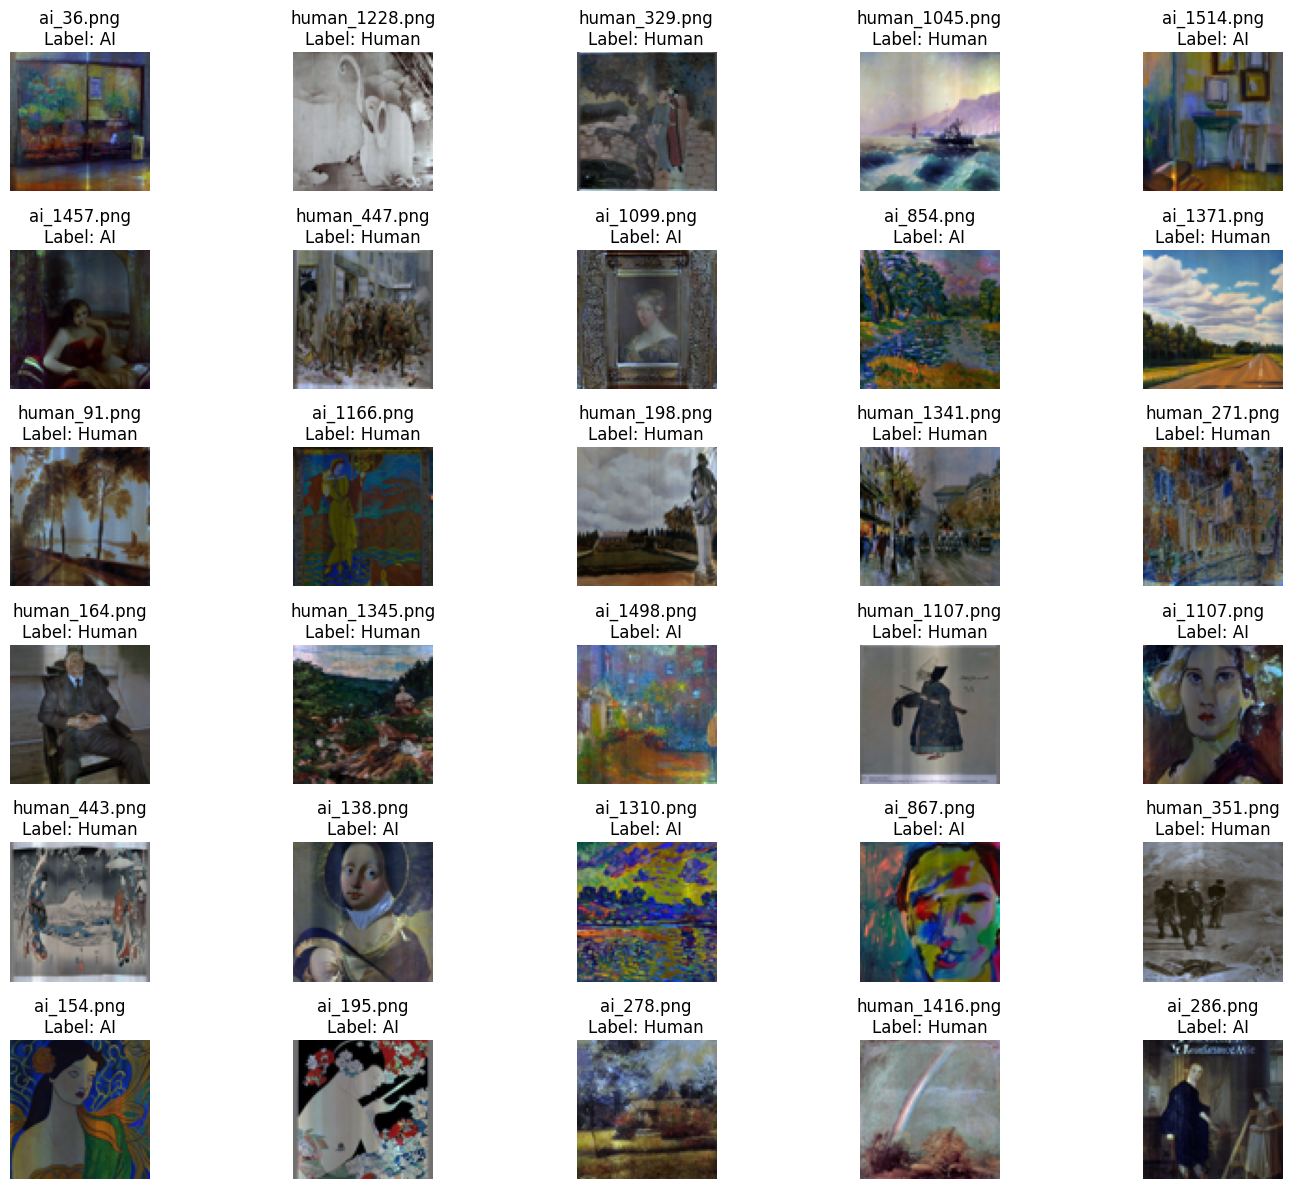

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import array_to_img

def plot_image(image_array, filename, label, ax):
    ax.imshow(array_to_img(image_array))
    ax.set_title(f"{filename}\nLabel: {label}")
    ax.axis('off')

num_images = 30
indices = np.random.choice(len(test_images), num_images, replace=False)

selected_images = test_images[indices]
selected_filenames = np.array(test_filenames)[indices]
selected_labels = predicted_labels[indices]


fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < num_images:
        plot_image(selected_images[i], selected_filenames[i], selected_labels[i], ax)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In the concluding phase of our project, we focused on deploying our trained model in a real-world scenario, applying it to a set of test data. This process entailed a thorough preparation phase, where images were meticulously loaded and preprocessed, aligning them for model compatibility. Subsequently, the model was employed to predict labels for this test dataset. To facilitate seamless distribution and analysis, the predicted labels, together with their corresponding image filenames and Base64-encoded representations, were meticulously compiled into a CSV file. This step ensures that our results are easily accessible for review and further interpretation.

# **Vision Transformer**

In [ ]:
# from transformers import ViTForImageClassification, ViTFeatureExtractor

# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=2)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [ ]:
# from torch.optim import Adam
# from torch.nn import CrossEntropyLoss
# from torch.optim.lr_scheduler import StepLR

# optimizer = Adam(model.parameters(), lr=0.001)  # Adjust the learning rate if necessary
# criterion = CrossEntropyLoss()

# scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# def train_epoch(model, data_loader, criterion, optimizer, scheduler, device):
#     model.train()
#     running_loss = 0.0
#     correct_predictions = 0

#     for images, labels in data_loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images).logits
#         loss = criterion(outputs, labels)

#         loss.backward()

#         optimizer.step()

#         running_loss += loss.item()
#         _, preds = torch.max(outputs, dim=1)
#         correct_predictions += torch.sum(preds == labels)

#     scheduler.step()  # Update the learning rate

#     epoch_loss = running_loss / len(data_loader)
#     epoch_acc = correct_predictions.double() / len(data_loader.dataset)
#     return epoch_loss, epoch_acc.item()

# num_epochs = 1  # or more
# for epoch in range(num_epochs):
#     train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss}, Accuracy: {train_acc}')

In [ ]:
# def evaluate(model, data_loader, criterion, device):
#     model.eval()
#     running_loss = 0.0
#     correct_predictions = 0

#     with torch.no_grad():
#         for images, labels in data_loader:
#             images = images.to(device)
#             labels = labels.to(device).long()

#             outputs = model(images).logits
#             loss = criterion(outputs, labels)
#             running_loss += loss.item()
#             _, preds = torch.max(outputs, dim=1)
#             correct_predictions += torch.sum(preds == labels)

#     epoch_loss = running_loss / len(data_loader)
#     epoch_acc = correct_predictions.double() / len(data_loader.dataset)
#     return epoch_loss, epoch_acc.item()

# val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
# print(f'Test Loss: {val_loss}, Test Accuracy: {val_accuracy}')

In our project's scope, after consultation with the professor, we limited our machine learning methodologies to logistic regression, MLP, and CNN. In light of this, the Vision Transformer was utilized purely for experimental purposes.

In our exploration of the Vision Transformer model, as introduced by Google Research, we conducted a preliminary test run to evaluate its feasibility for our project. Due to constraints in computational resources, we downscaled images to 75x75 pixels, allowing us to complete a single epoch within two hours. However, both training and validation accuracy stagnated around the 50% mark, indicating that the model's performance was suboptimal.(The result obtained from the local machine). The limited resolution may have deprived the Vision Transformer of the detailed data necessary for effective learning.The required resolution for this model is 224x224. Additionally, a comprehensive hyperparameter optimization, including fine-tuning of the learning rate, was not feasible within our project's time frame.

In conclusion, while the Vision Transformer exhibits promising capabilities, its application in environments with limited computational resources poses significant challenges. Optimal performance likely requires a delicate balance of data quality, model complexity, and hyperparameter tuning, which in turn necessitates substantial time investment and computational power.